In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
import numpy as np
import torch
import torch.nn as nn
import torch.utils
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from tqdm import tqdm
import os
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from SLIMNet import SoftNet, train_SoftNet, GetLoader
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText

def plot_parity(y_true, y_pred, name, dpi_num, y_pred_unc=None):
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    sns.set()
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', c = 'cornflowerblue', alpha=1, elinewidth=1)
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    ax = plt.gca()
    ax.set_aspect('equal')

    at = AnchoredText(
        f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR^2 = {r2:.3f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    plt.xlabel('Ground-Truth')
    plt.ylabel('Predicted')
    plt.savefig(f'{name}.png', dpi = dpi_num)

    plt.show()
    return


def plot_comp(y_t, y_p, name, dpi_num, num = 4, y_pred_unc=None):
    
    plt.figure(figsize=(9, 9))
    sns.set(style='ticks')
    color = ['#2878b5', '#9ac9db', '#f8ac8c', '#c82423']
    # color = ['#8ECFC9' ,'#FFBE7A', '#FA7F6F', '#82B0D2']
    # color = ['#A1A9D0','#F0988C','#B883D4','#9E9E9E']
    # color = ['#F27970','#BB9727','#54B345' ,'#32B897']
    color = ['#db3124', '#ffdf92', '#90bee0', '#4b74b2']
    for i in range(num):
        plt.subplot(2, 2 ,i+1)
        y_true = y_t[:, i]
        y_pred = y_p[:, i]
        axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
        axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        plt.plot([axmin, axmax], [axmin, axmax], '--k')
        plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', c = color[i], alpha=1, elinewidth=1)
        plt.xlim((axmin, axmax))
        plt.ylim((axmin, axmax))
        ax = plt.gca()
        ax.set_aspect('equal')
        at = AnchoredText(
        f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR^2 = {r2:.3f}", prop=dict(size=10), frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
        plt.xlabel(f'Ground-Truth of {i}')
        plt.ylabel(f'Predicted {i}')
        sns.despine()

    plt.savefig(f'{name}.png', dpi = dpi_num)
    plt.show()

In [2]:
data = pd.read_csv('PI1070.csv')
data = data.fillna(0)
maccs = []

for i in data['smiles']:
    molecule = Chem.MolFromSmiles(i) 
    fingerprints = MACCSkeys.GenMACCSKeys(molecule)
    maccs.append(list(fingerprints.ToBitString()))
    
X0 = np.array(maccs).astype('int') # (1077, 167)
X1 = np.array(data['mol_weight_monomer']).reshape(-1,1) #(1077, 1)
X2 = np.array(data['vdw_volume_monomer']).reshape(-1,1) #(1077, 1)
X3 = np.array(data['qm_total_energy_monomer']).reshape(-1,1) #(1077, 1)
X4 = np.array(data['qm_homo_monomer']).reshape(-1,1) #(1077, 1)
X5 = np.array(data['qm_lumo_monomer']).reshape(-1,1) #(1077, 1)
X6 = np.array(data['qm_dipole_monomer']).reshape(-1,1) #(1077, 1)
X7 = np.array(data['qm_polarizability_monomer']).reshape(-1,1) #(1077, 1)
X8 = np.array(data['DP']).reshape(-1,1) #(1077, 1)  
X9 = np.array(data['Mn']).reshape(-1,1) #(1077, 1)
X10 = np.array(data['density']).reshape(-1,1) #(1077, 1)
X11 = np.array(data['compressibility']).reshape(-1,1) #(1077, 1)
X12 = np.array(data['static_dielectric_const']).reshape(-1,1) #(1077, 1)
X13 = np.array(data['nematic_order_parameter']).reshape(-1,1) #(1077, 1)

y0 = np.array(data['thermal_conductivity']).reshape(-1,1)
y1 = np.array(data['thermal_diffusivity']).reshape(-1,1) #(1077, 1)
y2 = np.array(data['dielectric_const_dc']).reshape(-1,1) #(1077, 1)
y3 = np.array(data['volume_expansion']).reshape(-1,1) #(1077, 1)

y = np.concatenate((y0, y1, y2, y3), axis=1)
X = np.concatenate((X0, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13), axis=1)



In [3]:
# import numpy as np
# 
# train_id = np.random.choice(1077, 862, replace=False)
# # train_id = np.load('train_id.npy')
# test_id = np.setdiff1d(np.arange(1077), train_id, assume_unique=False)
# # print(train_id)
# print(train_id.shape)
# # print(train_id)
# print(test_id.shape)
# np.save('train_id.npy', train_id)
# np.save('test_id.npy', test_id)

MSE: 0.7466253411111639
MAE: 0.37444355761699055
R2: 0.4932235388653929


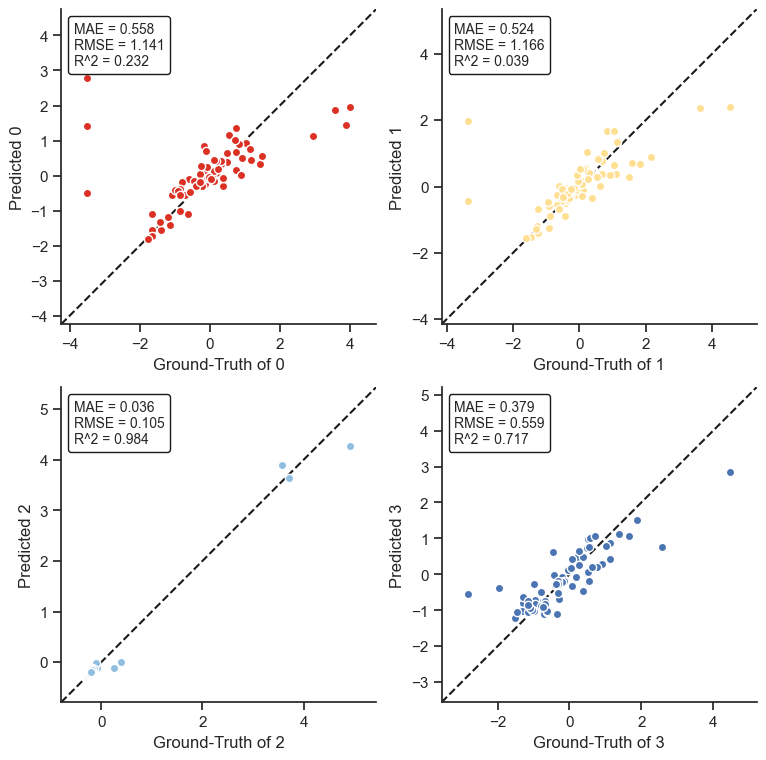

In [4]:
regressor = RandomForestRegressor(n_estimators=100,random_state=42)
scalar = StandardScaler()

X = scalar.fit_transform(X)
y = scalar.fit_transform(y)
# prop= 3
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

train_id = np.load('best_pt/train_id.npy')
test_id = np.load('best_pt/test_id.npy')

X_train, X_test = X[train_id], X[test_id]
y_train, y_test = y[train_id], y[test_id]

pipe = Pipeline([
    #('scaler', StandardScaler()), 
    #('reduce_dim', PCA()),
    ('regressor', regressor)
    ])
pipe.fit(X_train, y_train)
y_predict = pipe.predict(X_test)
print(f'MSE: {mean_squared_error(y_test,y_predict)}')
print(f'MAE: {mean_absolute_error(y_test,y_predict)}')
print(f'R2: {r2_score(y_test,y_predict)}')
plot_comp(y_test,y_predict,'RFtest', 700)

In [5]:
model = SoftNet(4)
train_data, test_data = GetLoader(X_train, y_train), GetLoader(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)
train_SoftNet(model, 7000, train_loader, test_loader, X_test, y_test,4, 10)

  0%|          | 0/7000 [00:00<?, ?it/s]

[5] train_loss: 33.86521, MAE: 0.49515, R2: 0.27339, Best MAE: 0.49515
saving checkpoint...
[10] train_loss: 29.85740, MAE: 0.45696, R2: 0.36918, Best MAE: 0.45696
saving checkpoint...
[15] train_loss: 26.61866, MAE: 0.43891, R2: 0.41480, Best MAE: 0.43891
saving checkpoint...
[20] train_loss: 24.72164, MAE: 0.44094, R2: 0.44556, Best MAE: 0.43891
[25] train_loss: 23.62304, MAE: 0.42522, R2: 0.43686, Best MAE: 0.42522
saving checkpoint...
[30] train_loss: 22.62555, MAE: 0.45337, R2: 0.41595, Best MAE: 0.42522
[35] train_loss: 21.77636, MAE: 0.43357, R2: 0.42508, Best MAE: 0.42522
[40] train_loss: 21.11166, MAE: 0.43098, R2: 0.43557, Best MAE: 0.42522
[45] train_loss: 20.86798, MAE: 0.41593, R2: 0.43152, Best MAE: 0.41593
saving checkpoint...
[50] train_loss: 20.57329, MAE: 0.42721, R2: 0.44300, Best MAE: 0.41593
[55] train_loss: 19.80148, MAE: 0.45300, R2: 0.38167, Best MAE: 0.41593
[60] train_loss: 19.51199, MAE: 0.42948, R2: 0.40278, Best MAE: 0.41593
[65] train_loss: 18.95995, MAE: 

KeyboardInterrupt: 

torch.Size([77, 180])
MSE: 0.2731781480194265
MAE: 0.29676144572488494
R2: 0.7981198156474382


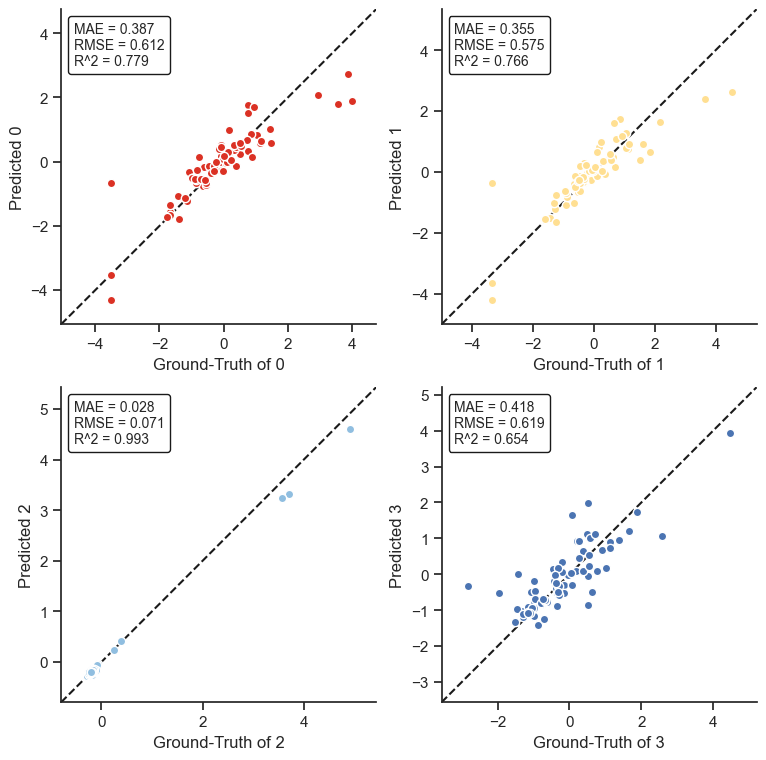

In [4]:

model = SoftNet(4)

path = f'best_pt/0_1/softnet-test029676.pt'
net_para_evidential = torch.load(path, map_location='cpu')
model.load_state_dict(net_para_evidential['model_state_dict'])
# model.load_state_dict(torch.load("swa_model.pt"))
model.eval()
print(torch.tensor(X_test).shape)

monomer_prop, scal, alpha, chain_order = model(torch.tensor(X_test).float())
beta = scal[:, :4]
gamma = scal[:, 4:]
mid = torch.pow(gamma, beta)
prop_guass = torch.mul(alpha, mid)
polymer_prop = chain_order + prop_guass
y_predict_softnet = polymer_prop.detach().numpy()

print(f'MSE: {mean_squared_error(y_test, y_predict_softnet)}')
print(f'MAE: {mean_absolute_error(y_test, y_predict_softnet)}')
print(f'R2: {r2_score(y_test, y_predict_softnet)}')

plot_comp(y_test,y_predict_softnet,'softnet_test', 1000)
